# Height Profile

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from RadarLidarWindSpeed import RadarLidarWindSpeed

In [ ]:
dateBegin = datetime(2020, 7, 1)
dateEnd = datetime(2020, 7, 31)
heightGrid = list(range(0,15000,50))

In [12]:
analysis = RadarLidarWindSpeed(dateBegin, dateEnd)
analysis.importDataset()
result = analysis.getHeightProfile()

<ipython-input-14-4a4486bfaea2>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.axes()


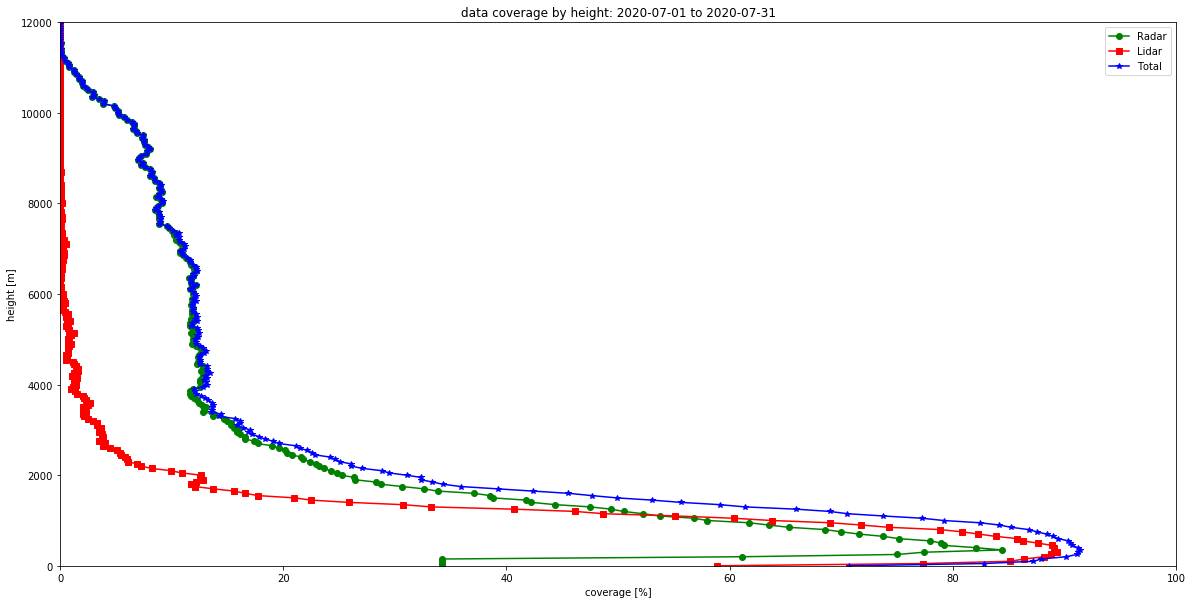

In [14]:
plt.figure(figsize=(20,10))
plt.plot(result['radar Coverage'].tolist(),heightGrid, 'go-', label='Radar')
plt.plot(result['lidar Coverage'].tolist(),heightGrid, 'rs-', label='Lidar')
plt.plot(result['total Coverage'].tolist(),heightGrid, 'b*-', label='Total')
axes = plt.axes()
axes.set_ylim([0, 12000])
axes.set_xlim([0, 100])
plt.xlabel("coverage [%]")
plt.ylabel("height [m]")
plt.legend()
plt.title('data coverage by height: '+dateBegin.strftime("%Y-%m-%d")+" to "+dateEnd.strftime("%Y-%m-%d"))
plt.show()